In [14]:
from river.drift.adwin import ADWIN
from river.naive_bayes import GaussianNB
from river.tree.hoeffding_tree_classifier import HoeffdingTreeClassifier
from river.datasets.synth.stagger import STAGGER

from fall.adaptive_learning import BaseAdaptiveLearner
from fall.concept_representations import ErrorRateRepresentation, FingerprintRepresentation
from fall.data.datastream import ConceptSegmentDataStream, make_stream_concepts
from fall.data.transition_patterns import circular_transition_pattern
from fall.data.utils import Concept, ConceptSegment, StateSegment
from fall.evaluation.monitoring import Monitor
from fall.evaluation.context_inference import plot_active_state_history, plot_ground_truth_contexts, plot_system_performance, plot_system_context_recall, plot_system_context_precision, calculate_cf1_score, calculate_context_to_state_max_f1
from fall.repository import AbsoluteValueComparer, CosineComparer

import ipywidgets as widgets



# Evaluation

FALL implements a number of tools specifically designed to evaluate adaptive learning systems.
While measures such as overall or rolling accuracy are important, these tools do not tell the full story when evaluating an adaptive learning system. Specifically, when evaluating adaptive approaches we are interested in estimating how the system will handle unknown changes in distribution in the future. These changes may have an arbitrary effect on accuracy. 

*Context Inference* is a state of the art set of tools for evaluating the performance of a system in handling future changes in distribution.

In the example below, we begin by constructing a data stream then running a classifier over it.

In [33]:
seed = 1
s0 = STAGGER(classification_function=0, seed=seed)
s1 = STAGGER(classification_function=1, seed=seed)
s2 = STAGGER(classification_function=2, seed=seed)
c0 = Concept(s0, "0")
c1 = Concept(s1, "1")
c2 = Concept(s2, "2")

n_repeats = 5
pattern = circular_transition_pattern(3, n_repeats, 1.0, 1, 0.0, shuffle_order=False, seed=seed)

segment_length = 5000
concept_segments = make_stream_concepts([c0, c1, c2], pattern, segment_length)

datastream = ConceptSegmentDataStream(concept_segments, 0, seed)

classifier = BaseAdaptiveLearner(
    classifier_constructor=lambda: EvolutionHoeffdingTree(grace_period=50),
    buffer_timeout_max=250,
    buffer_timeout_scheduler=get_increasing_buffer_scheduler(0.5),
    # representation_constructor=ErrorRateRepresentation,
    representation_constructor=FingerprintRepresentation,
    train_representation=True,
    construct_pair_representations=True,
    prediction_mode="all",
    # representation_comparer=AbsoluteValueComparer(),
    representation_comparer=CosineComparer(fisher_overall_weighting, weight_coef=0.1),
    drift_detector_constructor=lambda: ADWIN(delta=0.002),
    representation_window_size=20,
    representation_update_period=5,
    drift_detection_mode="lower",
)

for i, (X, y) in enumerate(datastream.take(datastream.n_samples)):
    classifier.predict_one(X, i)
    classifier.learn_one(X, y, timestep=i)


## Active state history

One of the most important pieces of information required for evaluation is the history of active states the adaptive learning system used over the stream.
For evaluation, this is saved into the _performance monitor_ object inside the system. (Note: This can and should be disabled for deployment in order to reduce memory costs.)

In [27]:
print(classifier.performance_monitor.active_state_history)

[0r1:0->3522, 1r0:3523->5221, 2r0:5222->9416, 3r0:9417->15179, 0r0:15180->17611, 4r0:17612->21326, 5r0:21327->30193, 6r0:30194->33780, 0r0:33781->35316, 4r0:35317->36468, 7r0:36469->39831, 4r0:39832->41975, 8r0:41976->44378, 9r0:44379->50301, 4r0:50302->52861, 10r0:52862->56288, 11r0:56289->60195, 6r0:60196->65347, 12r0:65348->74999]


The active state history stores segments describing each contiguous set of observations classified by each active state, in a timeline view.
The recurrences of each state are also captured.

In order to see patterns in the active state history, FALL contains visualization methods able to automatically plot these segments.

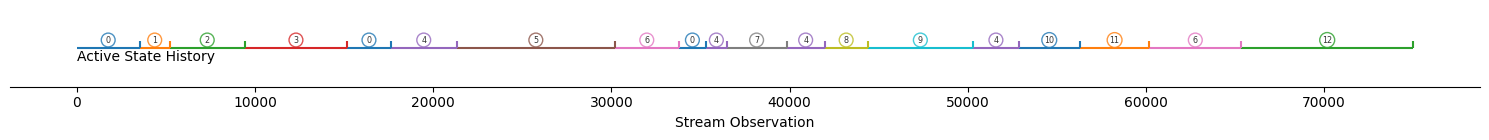

In [28]:
plot_active_state_history(classifier.performance_monitor.active_state_history)


In the above plot, we observe that some states are reoccuring over time. How does this correspond to the recurrences in the underlying contexts?
FALL also implements methods of plotting these ground truth context segments.

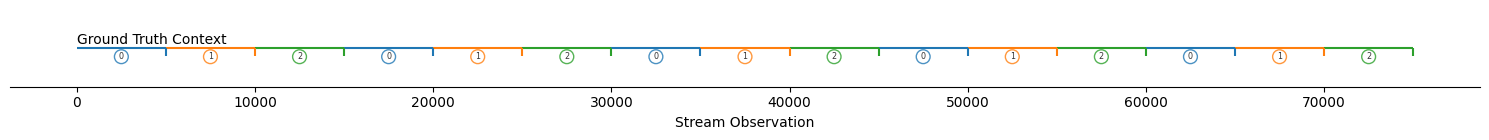

In [29]:
plot_ground_truth_contexts(datastream.concept_segments)

And for easier comparison, implements a method to plot both on a single chart.

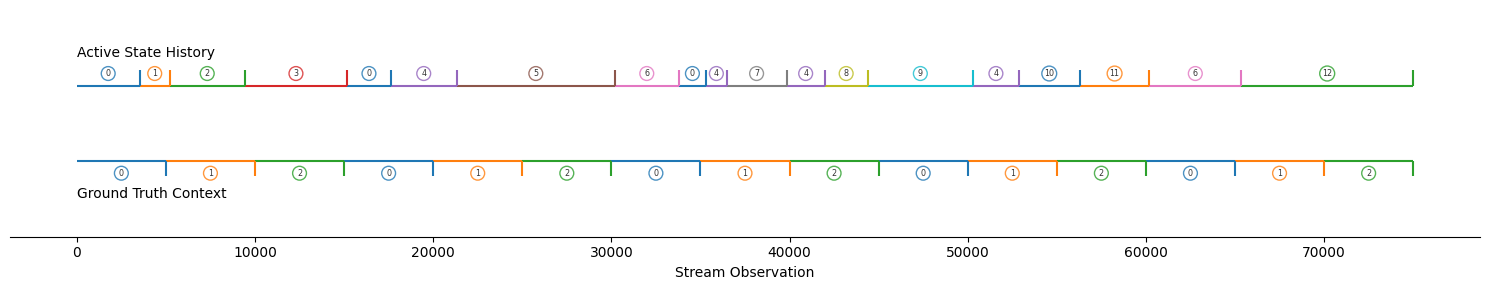

In [30]:
plot_system_performance(datastream.concept_segments, classifier.performance_monitor.active_state_history)

## State-context equivalence

From the above example, we observe that in an adaptive learning system, the states used by the system are related to the contexts underlying the stream.
This relationship is known as _state-context equivalence_, and is an important factor in estimating the ability of a system to adapt to future changes in distribution.

The idea is that a system with a strong state-context equivalence has shown a high ability to adapt to change and identify and reuse past experience, which is likely to generalize into the future.

### C-F1 measure

To measure state-context equivalence, FALL implements the _context-F1_ (C-F1) measure.
Essentially, C-F1 measures the recall and precision of the active state history and the ground truth context in order to quantify the relationship between them.

To show how this works, FALL implements methods to visualize the recall and precision between states and contexts.

In [8]:

@widgets.interact(context=(0, 2))
def f(context=0):
    plot_system_context_recall(datastream.concept_segments, classifier.performance_monitor.active_state_history, context)

interactive(children=(IntSlider(value=0, description='context', max=2), Output()), _dom_classes=('widget-inter…

In the above example, we are plotting the recall for context 0 against the state which achieves the maximum recall. We observe that a relatively high amount of recall is able to be achieved using this system. The recall between a context, state pair represents the amount of experience accumulated by the state which describes the context, and is successfully reused over the test stream.

In [9]:
@widgets.interact(context=(0, 2))
def f(context=0):
    plot_system_context_precision(datastream.concept_segments, classifier.performance_monitor.active_state_history, context)

interactive(children=(IntSlider(value=0, description='context', max=2), Output()), _dom_classes=('widget-inter…

In the above example, we perform a similar visualization using precision. The precision between a context, state pair represents the ability of a system to identify when experience is relevant, e.g., how quickly an active state is changed when a concept drift occurs.

### C-F1

The F1 score can be computed from the recall and precision of every state context pair. We are interested in the pair which achieves the maximum F1, e.g., the best recall and precision, for each context. FALL implements methods to do this.

In [31]:
calculate_context_to_state_max_f1(datastream.concept_segments, classifier.performance_monitor.active_state_history)

{0: 0.49740656213877116, 1: 0.3012351392785861, 2: 0.3250658258297305}

And finally, C-F1 is an average of the maximum F1 able to be achieved for each context, averaged over all contexts.

In [32]:
calculate_cf1_score(datastream.concept_segments, classifier.performance_monitor.active_state_history)

0.37456917574902926

C-F1 ranges from 0 to 1, with 1 being a perfect adaptive learning system. In this case, our system achieves a relatively good result, reflecting the visual match we identified earlier.

C-F1 is a state of the art adaptive learning measure, and has been recently shown to be linked to life-long classification performance in streaming data with changing contexts. FALL is the first framework to implement this analysis, making an essential tool for developing and implementing adaptive learning systems.